In [500]:
"""
В рамках проекта необходимо отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет 
на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

Для этого необходимо:
- проведите первичную обработку данных
- устанить некооректные данные и выбросы
- провести корреляционный анализ количественных переменных и отобрать не коррелирующие
- проанализировать качественные переменные и оставить только те, которые влияют на оценку
"""

'\nВ рамках проекта необходимо отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет \nна их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.\n\nДля этого необходимо:\n- проведите первичную обработку данных\n- устанить некооректные данные и выбросы\n- провести корреляционный анализ количественных переменных и отобрать не коррелирующие\n- проанализировать качественные переменные и оставить только те, которые влияют на оценку\n'

In [755]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import random as rnd

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

stud_math = pd.read_csv('F:\\stud_math.csv')

# процент значений моды в общем не пустом наборе, при котором пустые значения заменям модой
mode_percent_nan = 65

In [756]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [757]:
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [758]:
# сразу удаляем строки у которых 10% значений и более не заполнены (считаю, что вся строка в таком случае неиформативна).
stud_math = stud_math.dropna(thresh=27)

In [759]:
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               373 non-null    object 
 1   sex                  373 non-null    object 
 2   age                  373 non-null    int64  
 3   address              358 non-null    object 
 4   famsize              351 non-null    object 
 5   Pstatus              337 non-null    object 
 6   Medu                 371 non-null    float64
 7   Fedu                 353 non-null    float64
 8   Mjob                 357 non-null    object 
 9   Fjob                 346 non-null    object 
 10  reason               358 non-null    object 
 11  guardian             343 non-null    object 
 12  traveltime           352 non-null    float64
 13  studytime            371 non-null    float64
 14  failures             356 non-null    float64
 15  schoolsup            364 non-null    obj

In [760]:
# также сразу удаляем строки без оценки
stud_math = stud_math[pd.notnull(stud_math.score)]

In [761]:
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               367 non-null    object 
 1   sex                  367 non-null    object 
 2   age                  367 non-null    int64  
 3   address              354 non-null    object 
 4   famsize              345 non-null    object 
 5   Pstatus              331 non-null    object 
 6   Medu                 365 non-null    float64
 7   Fedu                 347 non-null    float64
 8   Mjob                 351 non-null    object 
 9   Fjob                 340 non-null    object 
 10  reason               352 non-null    object 
 11  guardian             337 non-null    object 
 12  traveltime           346 non-null    float64
 13  studytime            365 non-null    float64
 14  failures             350 non-null    float64
 15  schoolsup            358 non-null    obj

In [762]:
# переименовываем поля для удобства
stud_math.columns = ['school', 'sex', 'age', 'address', 'family_size', 'parent_status',
                     'mother_education', 'father_education', 'mother_job', 'father_job',
                     'reason', 'guardian', 'travel_time', 'study_time', 'failures', 'school_support',
                     'family_support', 'paid', 'activities', 'nursery', 'study_time_granular', 'higher',
                     'internet', 'romantic', 'family_relation', 'free_time', 'go_out', 'health', 'absences', 'score'
                     ]

In [763]:
# -----------------------------------------------------------
# Функция для получения информации по Daraframe.Series
# cur_column - Daraframe.Series
# corr_values - корректные значений, [] - если нет точных границ корректных значений
# add_info - 1 выводить для числовых данных информацию о статистических показателях, 0 - нет
# -----------------------------------------------------------
def column_info(cur_column, corr_values, add_info):
    count_nan = pd.isnull(cur_column).sum()
    count_not_nan = pd.notnull(cur_column).sum()
    len_corr_values = len(corr_values)
    bin_hist = cur_column.nunique()
    print("Количество уникальных значений:", cur_column.nunique())
    display(cur_column.value_counts())
    # выводим некорректные значения, пустые сюда не выводим
    if (len_corr_values != 0 and cur_column[~cur_column.isin(corr_values)][~pd.isnull(cur_column)].count() > 0):
        print("Некорректные значения:", "\n", cur_column[~cur_column.isin(
            corr_values)][~pd.isnull(cur_column)])
    else:
        print("Некорректных значений нет")
    if cur_column.dtype in ('float64', 'int64'):
        cur_column.hist(bins=bin_hist)
        cur_column.describe()
        if add_info == 1:
            median = cur_column.median()
            print("Медиана:", median)
            mean = cur_column.mean()
            print("Среднее арифметическое:", mean)
            mode = cur_column.mode()[0]
            print("Мода:", mode)
            IQR = cur_column.quantile(0.75) - cur_column.quantile(0.25)
            perc25 = cur_column.quantile(0.25)
            perc75 = cur_column.quantile(0.75)
            print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, "
                  .format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR)
                  )
            if cur_column[~cur_column.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)][~pd.isnull(cur_column)].count() > 0:
                print("Есть выбросы:", "\n", cur_column[~cur_column.between(
                    perc25 - 1.5*IQR, perc75 + 1.5*IQR)][~pd.isnull(cur_column)])
    if count_nan == 0:
        print("Отсутствующих значений(NaN) нет")
    else:
        print("Отсутствующих значений(NaN):", count_nan)
        mode = cur_column.mode()[0]
        mode_count = cur_column[cur_column == mode].count()
        mode_percent = round(mode_count / count_not_nan * 100)
        print("Мода:", mode, " , ", mode_percent, "% от непустых значений")
        if len_corr_values != 0:
            # Будем заполнять модой если значений моды в процентом соотношении больше mode_percent_nan (установил = 65)
            if mode_percent >= mode_percent_nan:
                print("Заменяем пустые значениями моды")
            else:  # иначе заполним случайными значениями из корректных
                print("Заменяем пустые случайными значениями из корректных")

In [764]:
# Функция заполнения пустого Daraframe.Series модой
def fill_column_mode(column):
    column.fillna(column.mode()[0], inplace=True)

In [765]:
# Функция заполнения пустого случайным значением из списка корректных
def fill_column_random(cur_column, corr_values):
    for i in cur_column[pd.isnull(cur_column)].index:
        cur_column[i] = rnd.choice(corr_values)

In [766]:
# Функция построения графиков boxplot
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=stud_math,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [767]:
# Функция нахождения статистически значимых различий
def get_stat_dif(column):
    cols = stud_math.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'],
                     stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [768]:
# -----------------------------------------------------------
# инициализация корректных значений полей, пусто если значения не ограничены
# -----------------------------------------------------------
yes_no = ['yes', 'no']  # чтобы не дублировать 'yes','no'
school_corr_values = []
sex_corr_values = ['F', 'M']
age_corr_values = [*range(15, 23)]
address_corr_values = ['U', 'R']
family_size_corr_values = ['LE3', 'GT3']
parent_status_corr_values = ['T', 'A']
mother_education_corr_values = [*range(0, 5)]
father_education_corr_values = [*range(0, 5)]
mother_job_corr_values = ['teacher', 'health', 'services', 'at_home', 'other']
father_job_corr_values = ['teacher', 'health', 'services', 'at_home', 'other']
reason_corr_values = ['home', 'reputation', 'course', 'other']
guardian_corr_values = ['mother', 'father', 'other']
travel_time_corr_values = [*range(1, 5)]
study_time_corr_values = [*range(1, 5)]
failures_corr_values = [*range(0, 4)]
school_support_corr_values = yes_no
family_support_corr_values = yes_no
paid_corr_values = yes_no
activities_corr_values = yes_no
nursery_corr_values = yes_no
study_time_granular_corr_values = []
higher_corr_values = yes_no
internet_corr_values = yes_no
romantic_corr_values = yes_no
family_relation_corr_values = [*range(1, 6)]
free_time_corr_values = [*range(1, 6)]
go_out_corr_values = [*range(1, 6)]
health_corr_values = [*range(1, 6)]
absences_corr_values = []
score_corr_values = [*range(0, 101)]

In [769]:
# обработаем пустые значения и выбросы

In [770]:
column_info(stud_math.school, school_corr_values, 0)

Количество уникальных значений: 2


GP    324
MS     43
Name: school, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


In [771]:
column_info(stud_math.sex, sex_corr_values, 0)

Количество уникальных значений: 2


F    196
M    171
Name: sex, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


Количество уникальных значений: 8


16    98
17    91
15    77
18    76
19    20
20     3
22     1
21     1
Name: age, dtype: int64

Некорректных значений нет
Медиана: 17.0
Среднее арифметическое: 16.678474114441418
Мода: 16
25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].
Есть выбросы: 
 247    22
Name: age, dtype: int64
Отсутствующих значений(NaN) нет


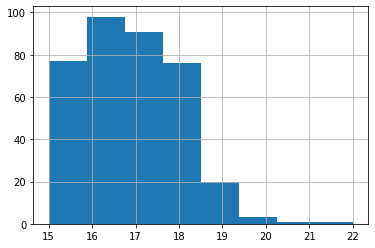

In [772]:
column_info(stud_math.age, age_corr_values, 1)

In [773]:
# не будем удалять строку с возрастом 22, т.к. изначально это исследование для лиц от 15 до 22 лет
# + если сделать допустимый предел чуть больше 1.5 межквартильных размаха, то значение попадет

In [774]:
column_info(stud_math.address, address_corr_values, 0)

Количество уникальных значений: 2


U    276
R     78
Name: address, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 13
Мода: U  ,  78.0 % от непустых значений
Заменяем пустые значениями моды


In [775]:
# заполняем пустые значения
# предполагаю, что школа находится в городе => из за города дольше добираться
stud_math.loc[((stud_math.address.isnull()) & (
    stud_math.travel_time > 2)), 'address'] = 'R'
stud_math.loc[((stud_math.address.isnull()) & (
    stud_math.travel_time <= 2)), 'address'] = 'U'
# если пустой и travel_time, то заполняем модой
fill_column_mode(stud_math.address)
column_info(stud_math.address, address_corr_values, 0)

Количество уникальных значений: 2


U    289
R     78
Name: address, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


In [776]:
column_info(stud_math.family_size, family_size_corr_values, 0)

Количество уникальных значений: 2


GT3    244
LE3    101
Name: family_size, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 22
Мода: GT3  ,  71.0 % от непустых значений
Заменяем пустые значениями моды


In [777]:
# заполняем пустые значения
fill_column_mode(stud_math.family_size)
column_info(stud_math.family_size, family_size_corr_values, 0)

Количество уникальных значений: 2


GT3    266
LE3    101
Name: family_size, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


In [778]:
column_info(stud_math.parent_status, parent_status_corr_values, 0)

Количество уникальных значений: 2


T    297
A     34
Name: parent_status, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 36
Мода: T  ,  90.0 % от непустых значений
Заменяем пустые значениями моды


In [779]:
# в среднем в семье 2 ребенка => если  family_size > 3, то 'T' - родители живут вместе
stud_math.loc[((stud_math['parent_status'].isnull()) & (
    stud_math['family_size'] == 'GT3')), 'parent_status'] = 'T'
# остальные заполним модой, в данном случае мода тоже = 'T'(но на другом наборе может и отличаться)
fill_column_mode(stud_math.parent_status)
column_info(stud_math.parent_status, parent_status_corr_values, 0)

Количество уникальных значений: 2


T    333
A     34
Name: parent_status, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


Количество уникальных значений: 5


4.0    123
2.0     92
3.0     92
1.0     55
0.0      3
Name: mother_education, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 2
Мода: 4.0  ,  34.0 % от непустых значений
Заменяем пустые случайными значениями из корректных


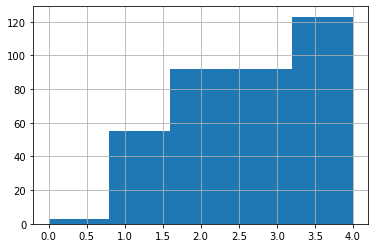

In [780]:
column_info(stud_math.mother_education, mother_education_corr_values, 0)

Количество уникальных значений: 5


4.0    123
2.0     93
3.0     92
1.0     55
0.0      4
Name: mother_education, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


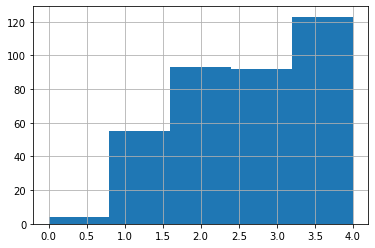

In [781]:
# Заменяем пустые случайными значениями из корректных
fill_column_random(stud_math.mother_education, mother_education_corr_values)
column_info(stud_math.mother_education, mother_education_corr_values, 0)

Количество уникальных значений: 6


2.0     95
3.0     89
4.0     87
1.0     73
0.0      2
40.0     1
Name: father_education, dtype: int64

Некорректные значения: 
 11    40.0
Name: father_education, dtype: float64
Отсутствующих значений(NaN): 20
Мода: 2.0  ,  27.0 % от непустых значений
Заменяем пустые случайными значениями из корректных


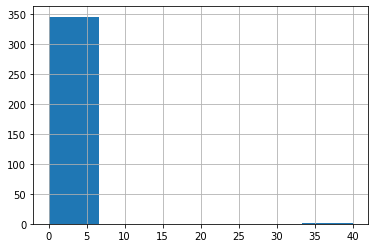

In [782]:
column_info(stud_math.father_education, father_education_corr_values, 0)

Количество уникальных значений: 5


2.0    97
3.0    96
4.0    94
1.0    75
0.0     5
Name: father_education, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


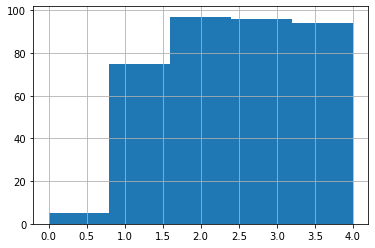

In [783]:
# Заменим некорректное значение 40 на 4(это скорее всего опечатка)
stud_math.loc[(stud_math['father_education'] == 40), 'father_education'] = 4
# Заменяем пустые случайными значениями из корректных
fill_column_random(stud_math.father_education, father_education_corr_values)
column_info(stud_math.father_education, father_education_corr_values, 0)

In [784]:
column_info(stud_math.mother_job, mother_job_corr_values, 0)

Количество уникальных значений: 5


other       120
services     92
at_home      56
teacher      53
health       30
Name: mother_job, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 16
Мода: other  ,  34.0 % от непустых значений
Заменяем пустые случайными значениями из корректных


In [785]:
# Заменяем пустые случайными значениями из корректных
fill_column_random(stud_math.mother_job, mother_job_corr_values)
column_info(stud_math.mother_job, mother_job_corr_values, 0)

Количество уникальных значений: 5


other       123
services     96
at_home      60
teacher      55
health       33
Name: mother_job, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


In [786]:
column_info(stud_math.father_job, father_job_corr_values, 0)

Количество уникальных значений: 5


other       185
services     96
teacher      28
at_home      16
health       15
Name: father_job, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 27
Мода: other  ,  54.0 % от непустых значений
Заменяем пустые случайными значениями из корректных


In [787]:
# Заменяем пустые случайными значениями из корректных
fill_column_random(stud_math.father_job, father_job_corr_values)
column_info(stud_math.father_job, father_job_corr_values, 0)

Количество уникальных значений: 5


other       188
services     98
teacher      39
at_home      21
health       21
Name: father_job, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


In [788]:
column_info(stud_math.reason, reason_corr_values, 0)

Количество уникальных значений: 4


course        131
reputation     95
home           95
other          31
Name: reason, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 15
Мода: course  ,  37.0 % от непустых значений
Заменяем пустые случайными значениями из корректных


In [789]:
# Заменяем пустые случайными значениями из корректных
fill_column_random(stud_math.reason, reason_corr_values)
column_info(stud_math.reason, reason_corr_values, 0)

Количество уникальных значений: 4


course        136
home           99
reputation     97
other          35
Name: reason, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


In [790]:
column_info(stud_math.guardian, guardian_corr_values, 0)

Количество уникальных значений: 3


mother    235
father     79
other      23
Name: guardian, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 30
Мода: mother  ,  70.0 % от непустых значений
Заменяем пустые значениями моды


In [791]:
# Заполним пустые значения модой
fill_column_mode(stud_math.guardian)
column_info(stud_math.guardian, guardian_corr_values, 0)

Количество уникальных значений: 3


mother    265
father     79
other      23
Name: guardian, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


Количество уникальных значений: 4


1.0    229
2.0     90
3.0     20
4.0      7
Name: travel_time, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 21
Мода: 1.0  ,  66.0 % от непустых значений
Заменяем пустые значениями моды


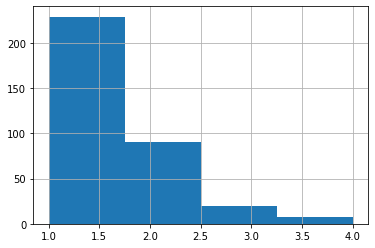

In [792]:
column_info(stud_math.travel_time, travel_time_corr_values, 0)

Количество уникальных значений: 4


1.0    250
2.0     90
3.0     20
4.0      7
Name: travel_time, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


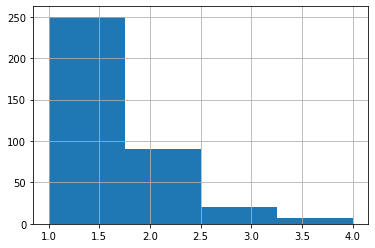

In [793]:
# Заполним пустые значения модой
fill_column_mode(stud_math.travel_time)
column_info(stud_math.travel_time, travel_time_corr_values, 0)

Количество уникальных значений: 4


2.0    181
1.0     95
3.0     62
4.0     27
Name: study_time, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 2
Мода: 2.0  ,  50.0 % от непустых значений
Заменяем пустые случайными значениями из корректных


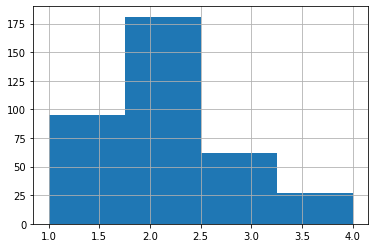

In [794]:
column_info(stud_math.study_time, study_time_corr_values, 0)

Количество уникальных значений: 4


2.0    181
1.0     95
3.0     64
4.0     27
Name: study_time, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


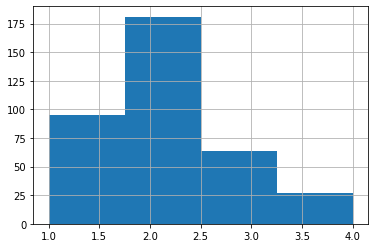

In [795]:
# Заполним пустые случайными
fill_column_random(stud_math.study_time, study_time_corr_values)
column_info(stud_math.study_time, study_time_corr_values, 0)

Количество уникальных значений: 4


0.0    278
1.0     44
2.0     14
3.0     14
Name: failures, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 17
Мода: 0.0  ,  79.0 % от непустых значений
Заменяем пустые значениями моды


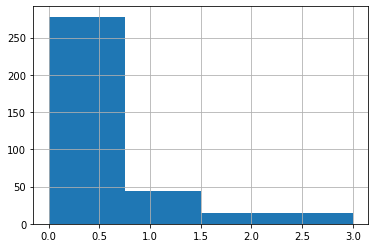

In [796]:
column_info(stud_math.failures, failures_corr_values, 0)

In [797]:
# Количество внеучебных неудач (n, если 1<=n<=3, иначе 0) крайне странное,
# т.к. 0 может значить как 0 неудач так и сколь угодно много.
# Считаю, что такая информация слишком противоречива. Удаляю этот столбец из данных.
del stud_math['failures']

In [798]:
column_info(stud_math.school_support, school_support_corr_values, 0)

Количество уникальных значений: 2


no     314
yes     44
Name: school_support, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 9
Мода: no  ,  88.0 % от непустых значений
Заменяем пустые значениями моды


In [799]:
# Заполним пустые значения модой
fill_column_mode(stud_math.school_support)
column_info(stud_math.school_support, school_support_corr_values, 0)

Количество уникальных значений: 2


no     323
yes     44
Name: school_support, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


In [800]:
column_info(stud_math.family_support, family_support_corr_values, 0)

Количество уникальных значений: 2


yes    211
no     124
Name: family_support, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 32
Мода: yes  ,  63.0 % от непустых значений
Заменяем пустые случайными значениями из корректных


In [801]:
# Заполним пустые случайными
fill_column_random(stud_math.family_support, family_support_corr_values)
column_info(stud_math.family_support, family_support_corr_values, 0)

Количество уникальных значений: 2


yes    228
no     139
Name: family_support, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


In [802]:
column_info(stud_math.paid, paid_corr_values, 0)

Количество уникальных значений: 2


no     189
yes    146
Name: paid, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 32
Мода: no  ,  56.0 % от непустых значений
Заменяем пустые случайными значениями из корректных


In [803]:
# Заполним пустые случайными
fill_column_random(stud_math.paid, paid_corr_values)
column_info(stud_math.paid, paid_corr_values, 0)

Количество уникальных значений: 2


no     211
yes    156
Name: paid, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


In [804]:
column_info(stud_math.activities, activities_corr_values, 0)

Количество уникальных значений: 2


yes    181
no     175
Name: activities, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 11
Мода: yes  ,  51.0 % от непустых значений
Заменяем пустые случайными значениями из корректных


In [805]:
# Заполним пустые случайными
fill_column_random(stud_math.activities, activities_corr_values)
column_info(stud_math.activities, activities_corr_values, 0)

Количество уникальных значений: 2


yes    184
no     183
Name: activities, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


In [806]:
column_info(stud_math.nursery, nursery_corr_values, 0)

Количество уникальных значений: 2


yes    280
no      72
Name: nursery, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 15
Мода: yes  ,  80.0 % от непустых значений
Заменяем пустые значениями моды


In [807]:
# Заполним пустые значения модой
fill_column_mode(stud_math.nursery)
column_info(stud_math.nursery, nursery_corr_values, 0)

Количество уникальных значений: 2


yes    295
no      72
Name: nursery, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


Количество уникальных значений: 4


-6.0     181
-3.0      95
-9.0      62
-12.0     27
Name: study_time_granular, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 2
Мода: -6.0  ,  50.0 % от непустых значений


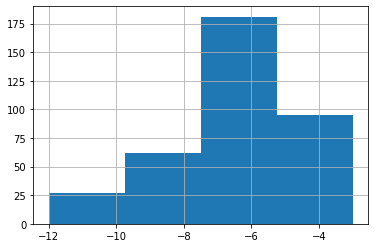

In [808]:
column_info(stud_math.study_time_granular, study_time_granular_corr_values, 0)

Количество уникальных значений: 4


-6.0     182
-3.0      95
-9.0      63
-12.0     27
Name: study_time_granular, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


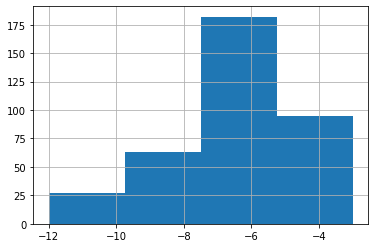

In [809]:
# Заполним пустые случайными (начальных данных нет о возможных значениях, заполняем теми которые есть в наличии)
fill_column_random(stud_math.study_time_granular, [-3, -6, -9, -12])
column_info(stud_math.study_time_granular, study_time_granular_corr_values, 0)

In [810]:
column_info(stud_math.higher, higher_corr_values, 0)

Количество уникальных значений: 2


yes    332
no      17
Name: higher, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 18
Мода: yes  ,  95.0 % от непустых значений
Заменяем пустые значениями моды


In [811]:
# Заполним пустые значения модой
fill_column_mode(stud_math.higher)
column_info(stud_math.higher, higher_corr_values, 0)

Количество уникальных значений: 2


yes    350
no      17
Name: higher, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


In [812]:
column_info(stud_math.internet, internet_corr_values, 0)

Количество уникальных значений: 2


yes    282
no      54
Name: internet, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 31
Мода: yes  ,  84.0 % от непустых значений
Заменяем пустые значениями моды


In [813]:
# Заполним пустые значения модой
fill_column_mode(stud_math.internet)
column_info(stud_math.internet, internet_corr_values, 0)

Количество уникальных значений: 2


yes    313
no      54
Name: internet, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


In [814]:
column_info(stud_math.romantic, romantic_corr_values, 0)

Количество уникальных значений: 2


no     226
yes    118
Name: romantic, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 23
Мода: no  ,  66.0 % от непустых значений
Заменяем пустые значениями моды


In [815]:
# Заполним пустые значения модой
fill_column_mode(stud_math.romantic)
column_info(stud_math.romantic, romantic_corr_values, 0)

Количество уникальных значений: 2


no     249
yes    118
Name: romantic, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


Количество уникальных значений: 6


 4.0    172
 5.0     88
 3.0     59
 2.0     17
 1.0      7
-1.0      1
Name: family_relation, dtype: int64

Некорректные значения: 
 25   -1.0
Name: family_relation, dtype: float64
Отсутствующих значений(NaN): 23
Мода: 4.0  ,  50.0 % от непустых значений
Заменяем пустые случайными значениями из корректных


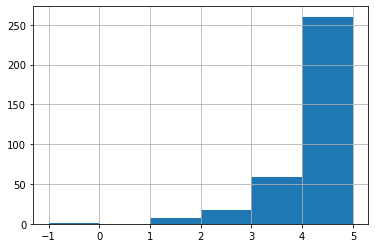

In [816]:
column_info(stud_math.family_relation, family_relation_corr_values, 0)

Количество уникальных значений: 5


4.0    175
5.0     93
3.0     64
2.0     23
1.0     12
Name: family_relation, dtype: int64

Некорректных значений нет
Медиана: 4.0
Среднее арифметическое: 3.8555858310626703
Мода: 4.0
25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].
Отсутствующих значений(NaN) нет


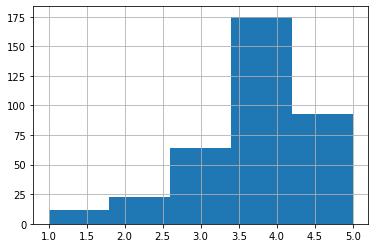

In [817]:
# Выбросы указаны из-за некорреткного значения -1
# Заменим некорректное значение -1 на 1(это скорее всего опечатка)
stud_math.loc[(stud_math['family_relation'] == -1), 'family_relation'] = 1
# Заполним пустые случайными
fill_column_random(stud_math.family_relation, family_relation_corr_values)
column_info(stud_math.family_relation, family_relation_corr_values, 1)

Количество уникальных значений: 5


3.0    145
4.0    106
2.0     60
5.0     33
1.0     16
Name: free_time, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 7
Мода: 3.0  ,  40.0 % от непустых значений
Заменяем пустые случайными значениями из корректных


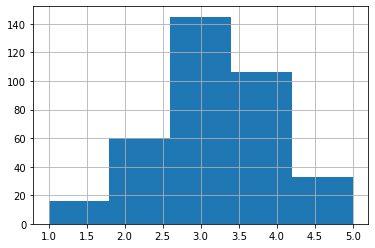

In [818]:
column_info(stud_math.free_time, free_time_corr_values, 0)

Количество уникальных значений: 5


3.0    149
4.0    106
2.0     60
5.0     36
1.0     16
Name: free_time, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


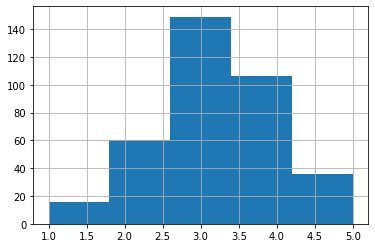

In [819]:
# Заполним пустые случайными
fill_column_random(stud_math.free_time, free_time_corr_values)
column_info(stud_math.free_time, free_time_corr_values, 0)

Количество уникальных значений: 5


3.0    121
2.0     92
4.0     77
5.0     47
1.0     23
Name: go_out, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 7
Мода: 3.0  ,  34.0 % от непустых значений
Заменяем пустые случайными значениями из корректных


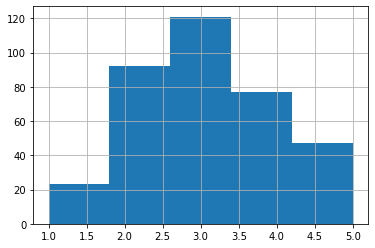

In [820]:
column_info(stud_math.go_out, go_out_corr_values, 0)

Количество уникальных значений: 5


3.0    123
2.0     95
4.0     79
5.0     47
1.0     23
Name: go_out, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


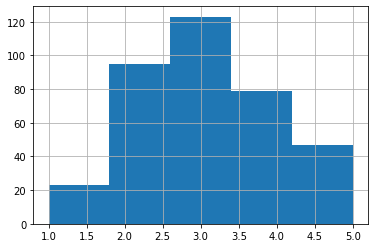

In [821]:
# Заполним пустые случайными
fill_column_random(stud_math.go_out, go_out_corr_values)
column_info(stud_math.go_out, go_out_corr_values, 0)

Количество уникальных значений: 5


5.0    127
3.0     86
4.0     56
1.0     44
2.0     41
Name: health, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN): 13
Мода: 5.0  ,  36.0 % от непустых значений
Заменяем пустые случайными значениями из корректных


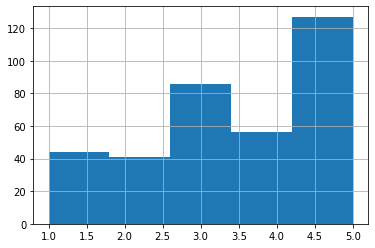

In [822]:
column_info(stud_math.health, health_corr_values, 0)

Количество уникальных значений: 5


5.0    129
3.0     89
4.0     58
1.0     46
2.0     45
Name: health, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


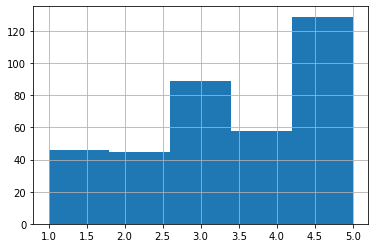

In [823]:
# Заполним пустые случайными
fill_column_random(stud_math.health, health_corr_values)
column_info(stud_math.health, health_corr_values, 0)

Количество уникальных значений: 35


0.0      107
2.0       55
4.0       49
6.0       27
8.0       20
10.0      16
12.0      12
14.0      10
16.0       7
3.0        7
7.0        6
5.0        5
18.0       5
20.0       4
9.0        3
1.0        3
15.0       2
13.0       2
22.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
19.0       1
38.0       1
40.0       1
23.0       1
11.0       1
17.0       1
28.0       1
Name: absences, dtype: int64

Некорректных значений нет
Медиана: 4.0
Среднее арифметическое: 7.335195530726257
Мода: 0.0
25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].
Есть выбросы: 
 40      25.0
74      54.0
103     26.0
183     56.0
198     24.0
205     28.0
216     22.0
222    385.0
260     21.0
276     75.0
277     22.0
307     38.0
315     40.0
320     23.0
390    212.0
Name: absences, dtype: float64
Отсутствующих значений(NaN): 9
Мода: 0.0  ,  30.0 % от непустых значений


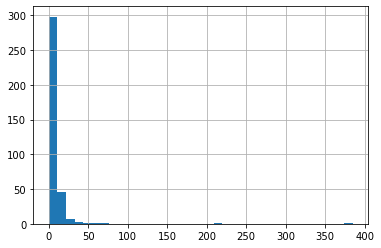

In [824]:
column_info(stud_math.absences, absences_corr_values, 1)

In [825]:
stud_math[stud_math.absences > 20][['absences', 'score']]

,absences,score
40,25.0,55.0
74,54.0,55.0
103,26.0,30.0
183,56.0,40.0
198,24.0,90.0
205,28.0,45.0
216,22.0,20.0
222,385.0,85.0
260,21.0,90.0
276,75.0,45.0


Количество уникальных значений: 28


0.0     116
2.0      55
4.0      49
6.0      27
8.0      20
10.0     16
12.0     12
14.0     10
16.0      7
3.0       7
7.0       6
18.0      5
5.0       5
20.0      4
1.0       3
9.0       3
13.0      2
15.0      2
22.0      2
11.0      1
26.0      1
24.0      1
28.0      1
25.0      1
21.0      1
19.0      1
23.0      1
17.0      1
Name: absences, dtype: int64

Некорректных значений нет
Отсутствующих значений(NaN) нет


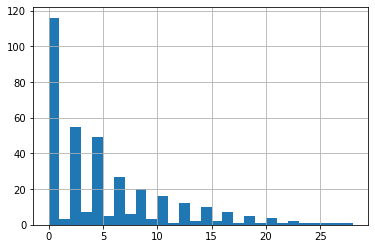

In [826]:
# Заполним пустые значения модой (т.к. 30% мода для числовой перменной достаточно, по моему мнению)
fill_column_mode(stud_math.absences)
# как видно количество пропусков сильно не сказалось на оценке(есть очень хорошие оценки у много пропустивших),так что, возможно,
# это просто ученики, которые перевелись из других учреждений, и поэтому у них столько пропусков,
# а на прежнем месте учебы могли отличаться многие показатели.
# Распеределение левое, логически буду считать выбросом и отсекать значения > 30
# Удаляем строки без оценки
stud_math = stud_math[stud_math.absences <= 30]
column_info(stud_math.absences, absences_corr_values, 0)

In [827]:
# Посмотрим корреляции

In [828]:
stud_math.corr()

,age,mother_education,father_education,travel_time,study_time,study_time_granular,family_relation,free_time,go_out,health,absences,score
age,1.000000,-0.157145,-0.152498,0.081702,-0.020892,0.027000,0.028156,0.009809,0.130273,-0.042287,0.132029,-0.142156
mother_education,-0.157145,1.000000,0.604345,-0.170212,0.098500,-0.103779,-0.014093,0.023108,0.053668,-0.050446,0.104115,0.221554
father_education,-0.152498,0.604345,1.000000,-0.121990,0.004818,-0.009267,-0.015330,-0.013147,0.054160,0.033872,0.029023,0.100676
travel_time,0.081702,-0.170212,-0.121990,1.000000,-0.101870,0.100077,-0.035950,0.010736,0.053197,-0.041798,-0.015527,-0.059338
study_time,-0.020892,0.098500,0.004818,-0.101870,1.000000,-0.998106,0.048140,-0.112243,-0.035950,-0.090968,-0.062337,0.112878
study_time_granular,0.027000,-0.103779,-0.009267,0.100077,-0.998106,1.000000,-0.047719,0.111612,0.032781,0.089989,0.067611,-0.111278
family_relation,0.028156,-0.014093,-0.015330,-0.035950,0.048140,-0.047719,1.000000,0.123683,0.026439,0.049431,-0.119644,0.091639
free_time,0.009809,0.023108,-0.013147,0.010736,-0.112243,0.111612,0.123683,1.000000,0.236362,0.076030,0.028618,0.032179
go_out,0.130273,0.053668,0.054160,0.053197,-0.035950,0.032781,0.026439,0.236362,1.000000,0.019749,0.100332,-0.114154
health,-0.042287,-0.050446,0.033872,-0.041798,-0.090968,0.089989,0.049431,0.076030,0.019749,1.000000,-0.027599,-0.082597


In [829]:
# Переменные study_time и study_time_granular обратно скоррелированы почти полностью, удаляем переменную study_time_granular
del stud_math['study_time_granular']

In [830]:
# Самая большая корреляция оценки с образованием матери, говорит о том ,
# что образованные матери уделяют больше времени развитию ребенка, благодаря чему он лучше успевает.
# Самая большая отрицательная корелляция с возрастом, что говорит о том, что с возрастом ученики теряют интерес к учебе.

In [831]:
# качественные поля
categorical_variable = ['school', 'sex', 'address', 'family_size', 'parent_status', 'mother_job', 'father_job', 'reason', 'guardian',
                        'school_support', 'family_support', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

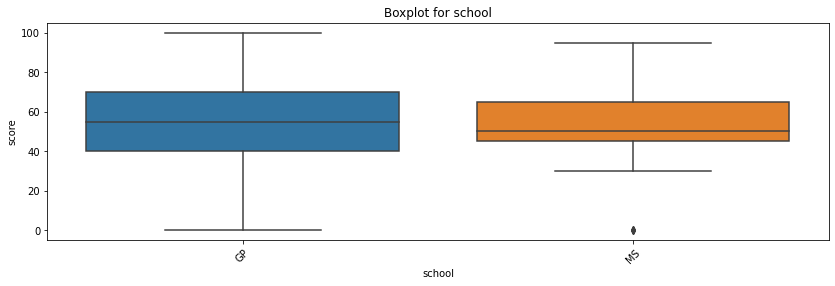

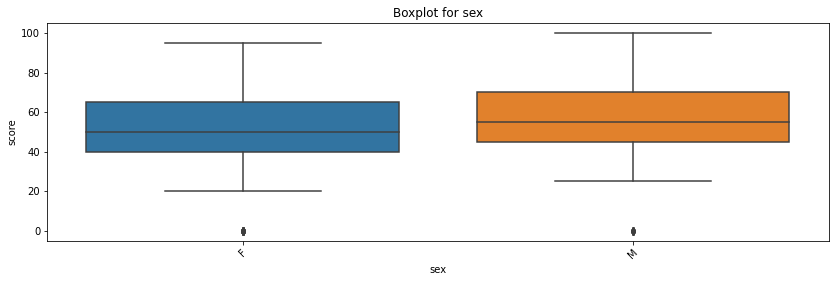

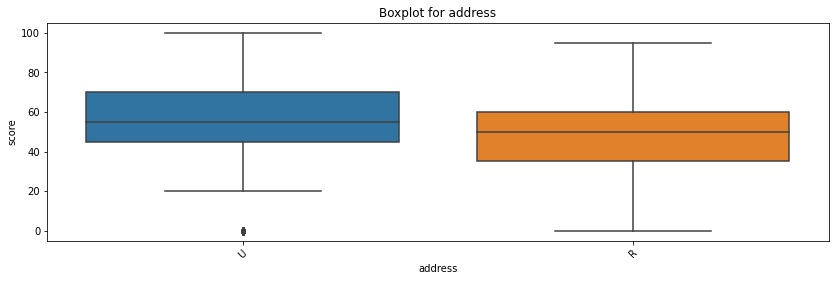

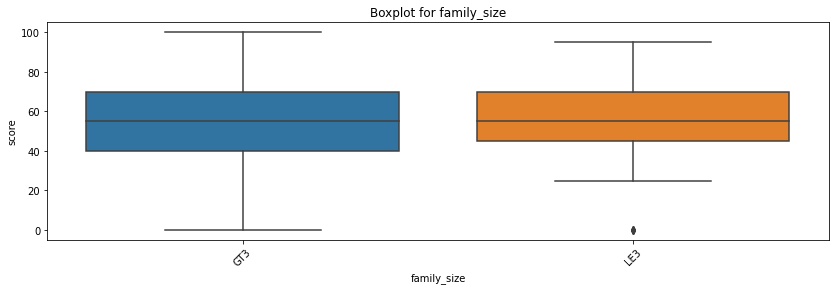

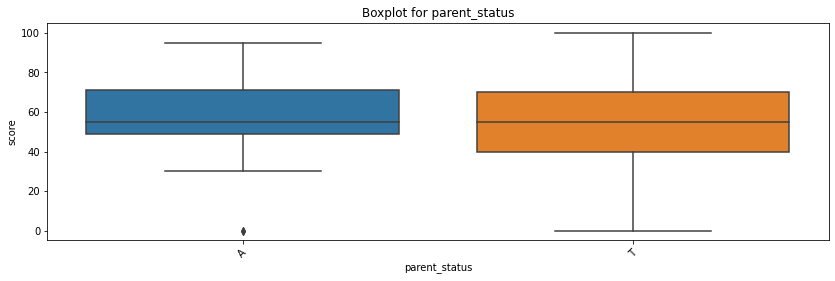

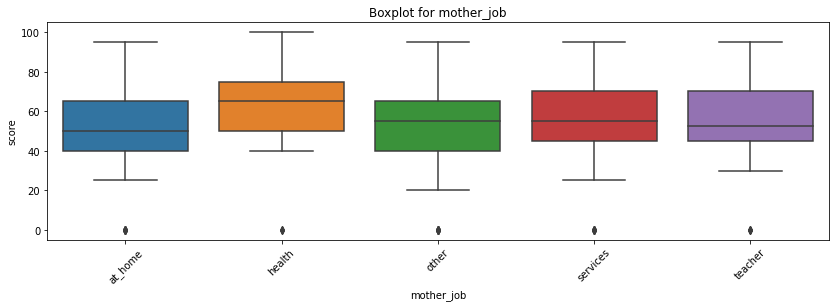

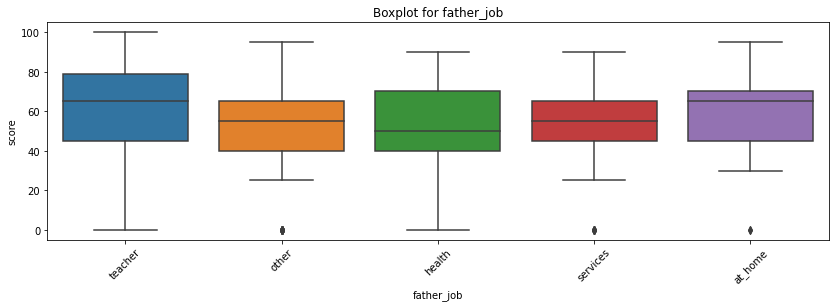

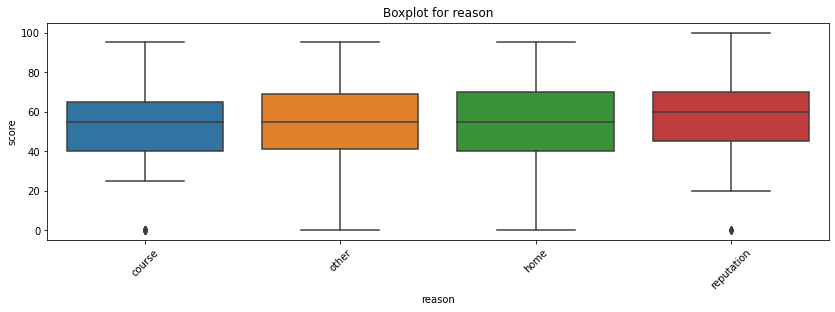

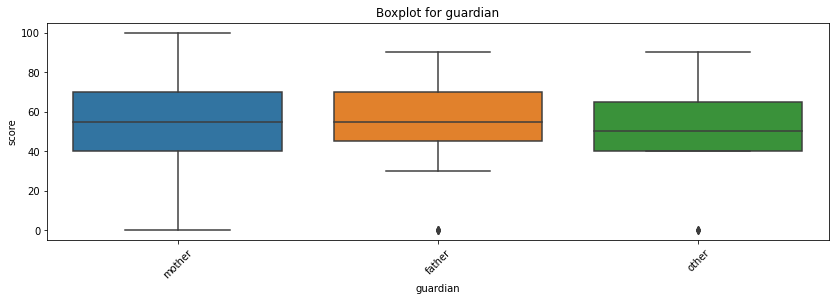

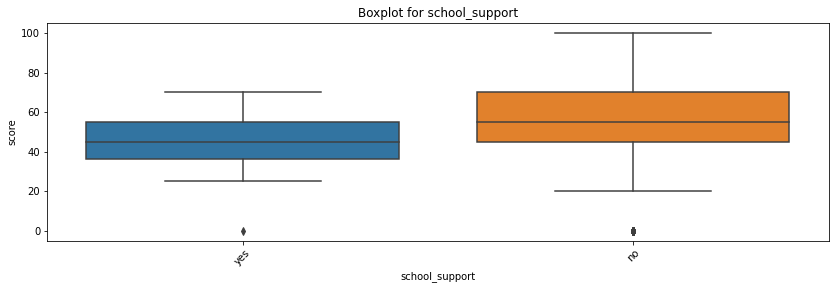

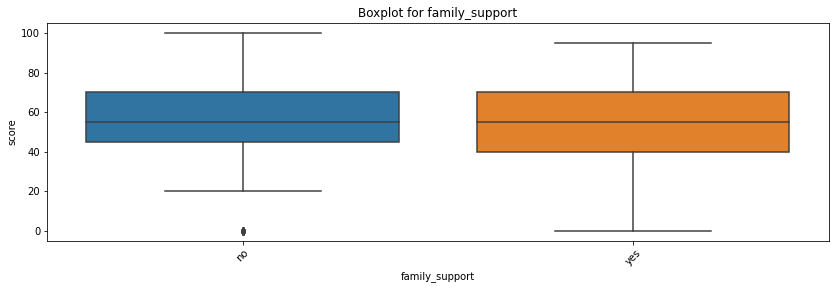

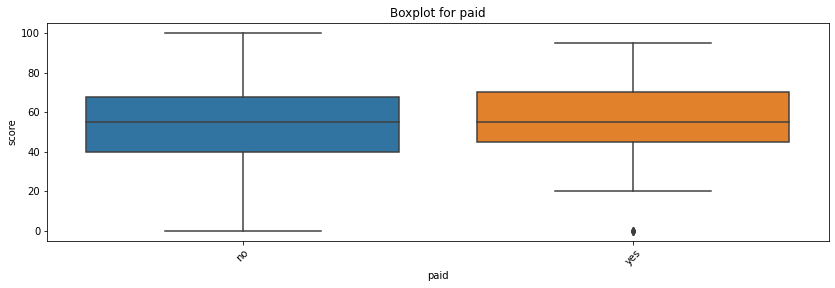

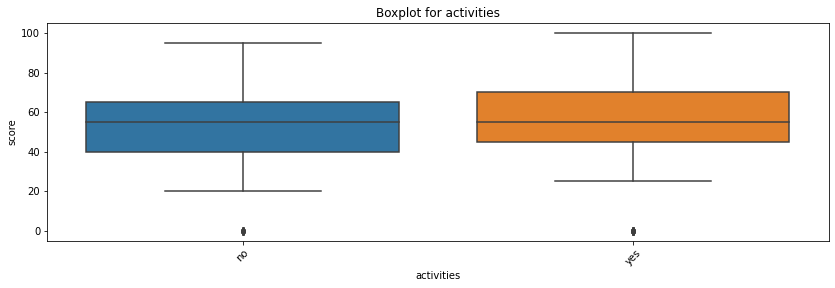

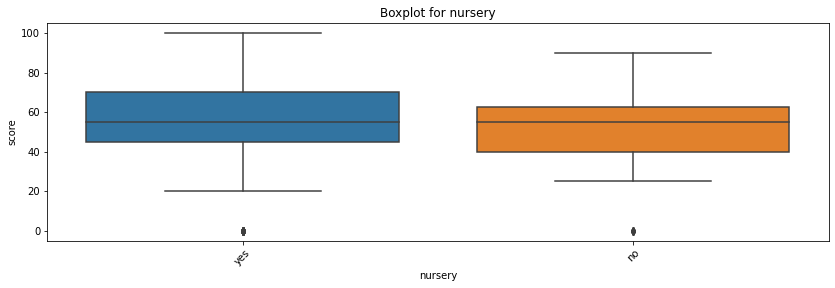

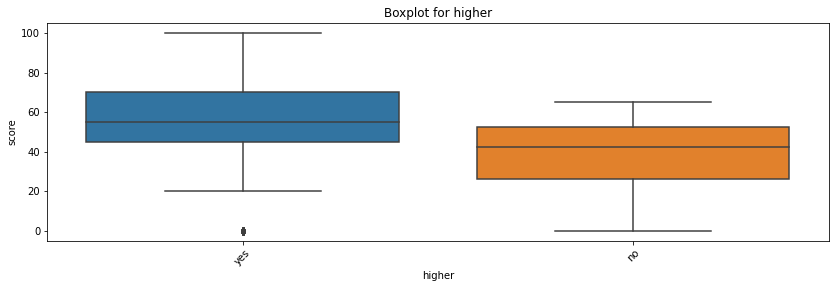

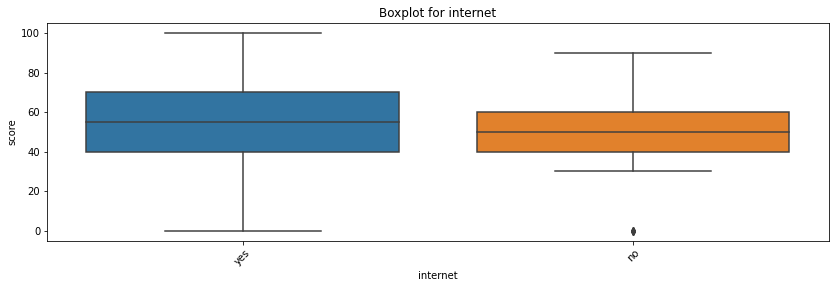

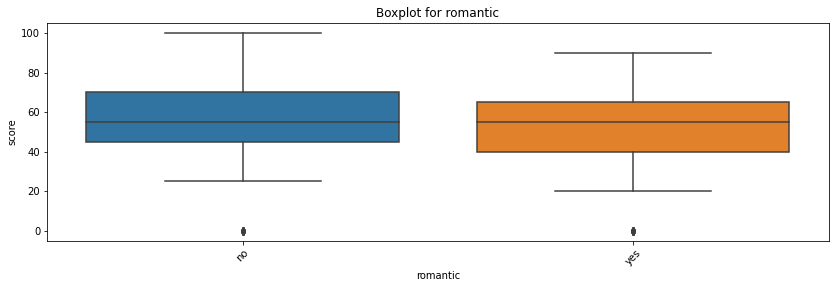

In [832]:
for col in categorical_variable:
    get_boxplot(col)

In [833]:
# Найдем статистически значимые различия для качественных полей

In [834]:
for col in categorical_variable:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки school_support
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


In [835]:
# ранговые поля
rank_variable = ['mother_education', 'father_education', 'travel_time', 'study_time', 'family_relation',
                 'free_time', 'go_out', 'health']

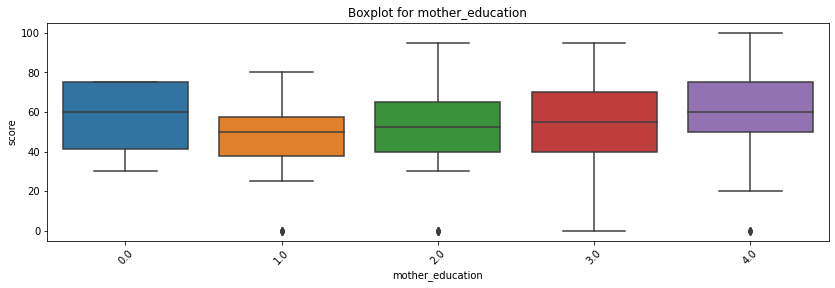

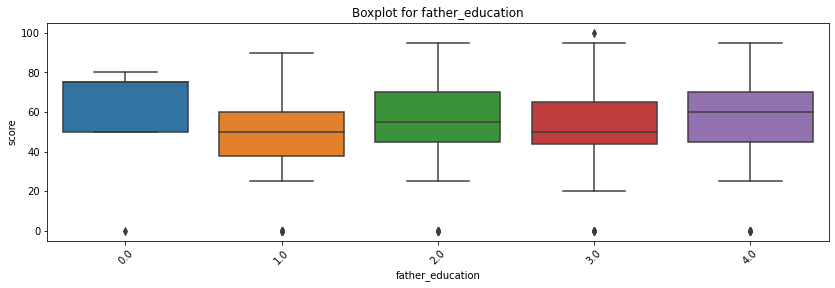

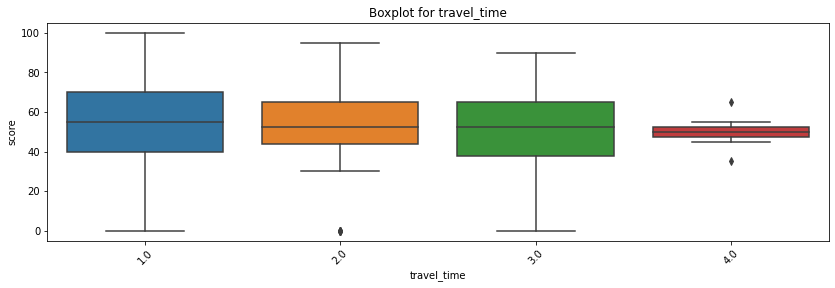

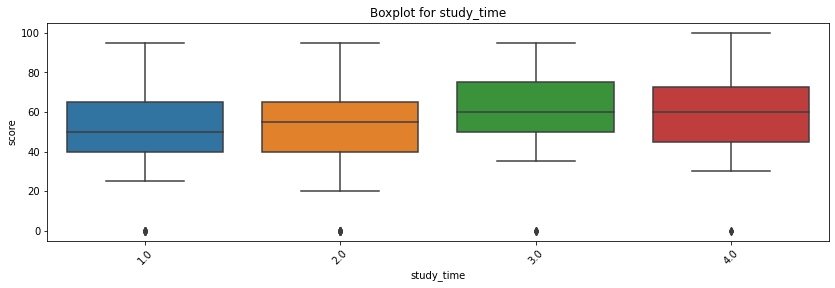

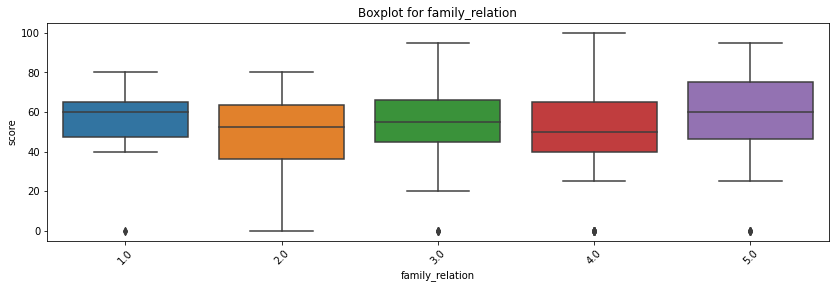

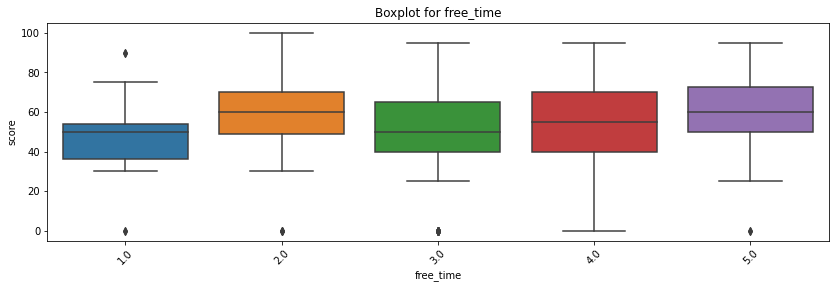

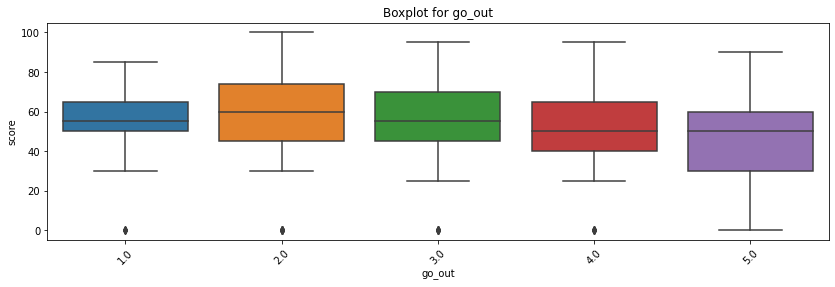

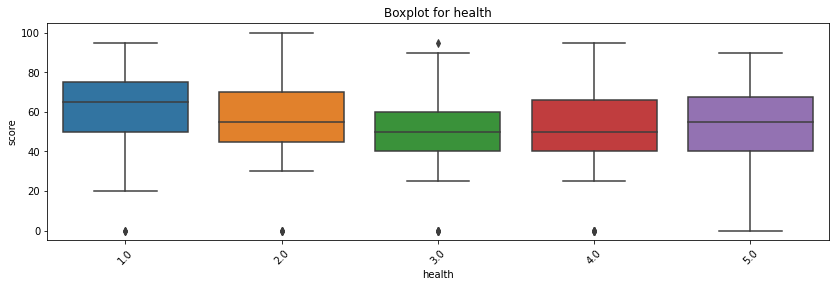

In [836]:
for col in rank_variable:
    get_boxplot(col)

In [837]:
# По ранговым перменным решил тоже опираться не на корреляцию, а на анализ статистически значимых различий
# Найдем статистически значимые различия для ранговых полей

In [838]:
for col in rank_variable:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки mother_education
Найдены статистически значимые различия для колонки go_out


In [ ]:
"""
Итоги:
В данных есть пустые значения, особенно много их в столбцах parent_status, family_support и paid.
Выбросы найдены в столбце absences, в столбце age я не счел значение выбросом и не стал его удалять. 
Так же найдены некорректные данные в столбцах father_education и family_relation. В целом считаю, что данные достаточно чистые.
Так же в данных присутствовал столбец failures, который сам по себе противоречив, и был удален.
Самая большая корреляция оценки с образованием матери, говорит о том , что образованные матери уделяют больше времени развитию ребенка, благодаря чему он лучше успевает.
Самая большая отрицательная корелляция с возрастом, что говорит о том, что с возрастом ученики теряют интерес к учебе.
Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это 
age
absences
sex
address
mother_job
school_support
higher
romantic
mother_education
go_out
"""